# Adapting a process based cold hardiness model to conifers
#### Miro Stuke - Stuke@uw.edu

This notebooks shows an example of the conifer cold hardiness model presented by Miro Stuke at the 2023 WFNCA grower's meeting. The model and example used here were also used for the related paper (in review; Stuke 2023).

The cold hardiness observations used in this modeling example were derived from Douglas-fir nursery grown seedling data published in Timmis et al., 1994. Two seedlots (high elevation and low elevation) were tested over four dormancy seasons from 1973 to 1978.

This notebook shows an example using one year of data and modeling both seed sources. 

All seedlings were grown at Mima nursery in south Olympia, WA as bareroot 2+0 nursery stock.

The cold hardiness model used here was modified and adapted from Ferguson et al. 2014 - a model used for grapes.

The data is split into training data - which will be used to calibrate the model and derive the best set of parameters for each seed lot, and testing data - will will be used to measure model performance and predictive accuarcy. 


In [1]:
#some packages need to be added to run the moedl
using Cropbox

WebIO._IJuliaInit()

In [2]:
using CSV
using DataFrames
using TimeZones
using Dates

# Temperature Data
Once the model is calibrated, it will run with just the input of daily minimum and maximum temperature for the period to be modeled. Each year has one temperature csv file and a unique configuration. The files will be and conifugrations will be added in the next section of script. 

In [3]:
Temp_1974 = CSV.read("D.6_TempData_74.CSV", DataFrame) |> unitfy

Row,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,date,Tavg,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES
,String15,String31,Float64,Float64,Float64,Date,Quantity…,Float64,Missing,Int64,String3,Int64,String3,Missing,Missing
1,USW00024227,"OLYMPIA AIRPORT, WA US",46.9737,-122.905,60.9,1974-10-01,16.3889 °C,61.5,missing,82,",,0",41,",,0",missing,missing
2,USW00024227,"OLYMPIA AIRPORT, WA US",46.9737,-122.905,60.9,1974-10-02,14.4444 °C,58.0,missing,68,",,0",48,",,0",missing,missing
3,USW00024227,"OLYMPIA AIRPORT, WA US",46.9737,-122.905,60.9,1974-10-03,11.1111 °C,52.0,missing,67,",,0",37,",,0",missing,missing
4,USW00024227,"OLYMPIA AIRPORT, WA US",46.9737,-122.905,60.9,1974-10-04,10.0 °C,50.0,missing,63,",,0",37,",,0",missing,missing
5,USW00024227,"OLYMPIA AIRPORT, WA US",46.9737,-122.905,60.9,1974-10-05,9.16667 °C,48.5,missing,64,",,0",33,",,0",missing,missing
6,USW00024227,"OLYMPIA AIRPORT, WA US",46.9737,-122.905,60.9,1974-10-06,9.16667 °C,48.5,missing,67,",,0",30,",,0",missing,missing
7,USW00024227,"OLYMPIA AIRPORT, WA US",46.9737,-122.905,60.9,1974-10-07,11.9444 °C,53.5,missing,72,",,0",35,",,0",missing,missing
8,USW00024227,"OLYMPIA AIRPORT, WA US",46.9737,-122.905,60.9,1974-10-08,13.3333 °C,56.0,missing,74,",,0",38,",,0",missing,missing
9,USW00024227,"OLYMPIA AIRPORT, WA US",46.9737,-122.905,60.9,1974-10-09,10.5556 °C,51.0,missing,63,",,0",39,",,0",missing,missing


In [4]:
D6_1974_config = @config (
    :Calendar => (;
        init = ZonedDateTime(1974, 10, 01, tz"UTC"),
        last = ZonedDateTime(1975, 05, 01, tz"UTC"),
    ),
    :Clock => (;
        step = 1u"d",
    ),
    :Temperature => (;
        data = Temp_1974,
    ),
)

init,=,"ZonedDateTime(1974, 10, 1, tz""UTC"")"
last,=,"ZonedDateTime(1975, 5, 1, tz""UTC"")"
step,=,1 d
data,=,213×15 DataFrame…


In [5]:
@system Temperature begin
    calendar(context)             ~      ::Calendar
    t(calendar.date): date        ~ track::date

    data                          ~ provide(parameter, index = :date, init = t)
    T:                temperature ~ drive(from = data, by = :Tavg, u"°C")
end

Temperature

# Observations
Observations will be added using csv files seed source. Seed sources are split into high and low elevation, which reflects two unique seedlots. Each file contains observations for one dormancy season, designated by the first year of that period.

Additionally each is divided into training and testing ata subsets. Training data are used for model calibration and parameterization. Testing data are used to validate the model and determine goodness of fit. 

In [6]:
Hc_Obs_Low =  CSV.read("Hc_Obs_Low.csv", DataFrame) |> unitfy

Row,Year,SeedSource,JD Rounded,date,Hc
,Int64,String3,Int64,Date,Quantity…
1,1974,Low,-71,1974-10-22,-5.6 K
2,1974,Low,-40,1974-11-22,-18.0 K
3,1974,Low,1,1975-01-02,-23.5 K
4,1974,Low,20,1975-01-21,-23.5 K
5,1974,Low,61,1975-03-03,-21.4 K
6,1974,Low,77,1975-03-19,-15.0 K
7,1974,Low,104,1975-04-15,-8.8 K
8,1976,Low,-100,1976-09-23,-5.5 K
9,1976,Low,-90,1976-10-03,-5.2 K


In [7]:
Hc_Obs_High =  CSV.read("Hc_Obs_High.csv", DataFrame) |> unitfy

Row,Year,SeedSource,JD Rounded,date,Hc
,Int64,String7,Int64,Date,Quantity…
1,1976,High,-26,1976-12-06,-24.1 K
2,1976,High,3,1977-01-04,-21.7 K
3,1976,High,10,1977-01-11,-26.9 K
4,1976,High,36,1977-02-06,-24.5 K
5,1976,High,48,1977-02-18,-23.0 K
6,1976,High,61,1977-03-01,-22.0 K
7,1976,High,75,1977-03-15,-18.9 K
8,1977,High,-81,1977-10-12,-7.0 K
9,1977,High,-67,1977-10-26,-9.5 K


In [8]:
LowTrain = CSV.read("LowTrain.csv", DataFrame) |> unitfy

Row,Index,Year,SeedSource,JDay,date,Hc
,Int64,Int64,String3,Int64,Date,Quantity…
1,20,1976,Low,75,1977-03-16,-19.8 K
2,25,1977,Low,1,1977-01-02,-24.0 K
3,11,1976,Low,-75,1976-10-18,-5.7 K
4,13,1976,Low,-39,1976-11-23,-15.4 K
5,7,1974,Low,104,1975-04-15,-8.8 K
6,2,1974,Low,-40,1974-11-22,-18.0 K
7,1,1974,Low,-71,1974-10-22,-5.6 K
8,15,1976,Low,2,1977-01-03,-24.1 K
9,21,1977,Low,-81,1977-10-12,-6.1 K


In [9]:
HighTrain = CSV.read("HighTrain.csv", DataFrame) |> unitfy

Row,Index,Year,SeedSource,JDay,date,Hc
,Int64,Int64,String7,Int64,Date,Quantity…
1,21,1974,High,24,1975-01-25,-24.4 K
2,7,1976,High,75,1977-03-15,-18.9 K
3,8,1977,High,-81,1977-10-12,-7.0 K
4,18,1974,High,-71,1974-10-22,-6.1 K
5,4,1976,High,36,1977-02-06,-24.5 K
6,13,1977,High,8,1978-01-09,-27.1 K
7,6,1976,High,61,1977-03-01,-22.0 K
8,17,1977,High,86,1978-03-28,-9.6 K
9,20,1974,High,1,1975-01-02,-24.0 K


In [10]:
LowTest = CSV.read("LowTest.csv", DataFrame) |> unitfy

Row,Index,Year,SeedSource,JDay,date,Hc
,Int64,Int64,String3,Int64,Date,Quantity…
1,4,1974,Low,20,1975-01-21,-23.5 K
2,5,1974,Low,61,1975-03-03,-21.4 K
3,10,1976,Low,-86,1976-10-07,-5.7 K
4,16,1976,Low,10,1977-01-11,-26.2 K
5,18,1976,Low,48,1977-02-18,-23.6 K
6,19,1976,Low,61,1977-03-02,-20.2 K
7,24,1977,Low,-26,1977-12-06,-24.2 K
8,26,1977,Low,8,1978-01-09,-24.0 K
9,28,1977,Low,53,1978-02-21,-21.8 K


In [11]:
 HighTest = CSV.read("HighTest.csv", DataFrame) |> unitfy

Row,Index,Year,SeedSource,JDay,date,Hc
,Int64,Int64,String7,Int64,Date,Quantity…
1,2,1976,High,3,1977-01-04,-21.7 K
2,3,1976,High,10,1977-01-11,-26.9 K
3,11,1977,High,-26,1977-12-06,-23.4 K
4,12,1977,High,1,1977-01-01,-27.0 K
5,14,1977,High,24,1978-01-25,-27.9 K
6,19,1974,High,-40,1974-11-22,-17.0 K
7,23,1974,High,77,1975-03-19,-16.1 K


# Cold hardienss model
The cold hardiness model used here divides cold hardiness during dormancy into two phases, acclimation (fall into winter) and deacclimation (winter into spring). These two phases are switched between based on a required chilling accumulation. Model formulas are shown below and model implementation is the code chunk at the bottom of this section.  

- Cold Hardiness Model Parameters

| Symbol | Example Parameter Value | Units | Description |
|:-------|:------|:------|:------------|
| $H_{\mathrm{c}}$ | - | °$\mathrm{C}$ | Cold Hardiness |
| $H_{\mathrm{c, i}}$ | -2.40 | °$\mathrm{C}$ | Initial Cold Hardiness Value |
| $H_{\mathrm{c, ll}}$ | -17.4 / -22.0 | °$\mathrm{C}$ |Lower Limit of Cold Hardiness Temperature (Most Hardy) |
| $H_{\mathrm{c, ul}}$ | -2.33 |°$\mathrm{C}$ | Upper Limit of Cold Hardiness Temperature (Least Hardy) |
| $T_{\mathrm{th,a}}$ | 9.43 | °$\mathrm{C}$ | Threshold temperature for degree-days during acclimation | 
| $T_{\mathrm{th,d}}$ | 8.63 | °$\mathrm{C}$ | Threshold temperature for degree-days during deacclimation | 
| $R_{\mathrm{c}}$ | -252 | °$\mathrm{C}$ | Chilling requirement |
| $R_{\mathrm{f}}$ | 395 | °$\mathrm{C}$ | Forcing requirement |
| $k_{\mathrm{a}}$ | 0.12 |°$\mathrm{C}$ °$\mathrm{C^{-1}}$| Acclimation rate during acclimation |
| $k_{\mathrm{d}}$ | 1.81 |°$\mathrm{C}$ °$\mathrm{C^{-1}}$| Deacclimation rate during deacclimation || $T_{\mathrm{max}}$ | - | °$\mathrm{C}$ | Maximum Daily Temperature |
| $T_{\mathrm{mean}}$ | - | °$\mathrm{C}$ | Mean Daily Temperature |
| $T_{\mathrm{min}}$ | - | °$\mathrm{C}$ | Minimum Daily Temperature |
| $DD_{\mathrm{c}}$ | - |°$\mathrm{C}$ |Chilling degree-days |
| $DD_{\mathrm{f}}$ | - |°$\mathrm{C}$ | Forcing degree-days |

- $H_{\mathrm{c}}$ values are always negative

- Equation 1: Average Daily Temperature 
$$
\begin{align}
T_{\mathrm{mean}} &= \frac{(T_{\mathrm{max}} + T_{\mathrm{min}})}{2}
\end{align}
$$

- Equation 2: Degree Day
$$
DD = T_{\mathrm{mean}} - T_{\mathrm{th}}
$$

- Equation 3: Changes in acclimation or deacclimation

                                                    If forcing requirement has not been met. 
$$
ΔH_{\mathrm{c}} = (DD_{\mathrm{c}} * k_{\mathrm{a}} *  c_{\mathrm{log, a}}) 
$$
                                                    If forcing requirement has been met.
$$
ΔH_{\mathrm{c}} = (DD_{\mathrm{f}} * k_{\mathrm{d}} *  c_{\mathrm{log, d}})
$$

- Equation 4: Acclimation logistic fuction
$$
\begin{align}
c_{\mathrm{log, a}} &= \frac{ H_{\mathrm{c, ll}} - H_{\mathrm{c, i-1}}}{ H_{\mathrm{c, ll}} - H_{\mathrm{c, ul}}} \\
\end{align}
$$

- Equation 5: Deacclimation logistic fuction
$$
\begin{align}
c_{\mathrm{log, d}} &= \frac{ H_{\mathrm{c, i-1}} - H_{\mathrm{c, ul}}}{ H_{\mathrm{c, ll}} - H_{\mathrm{c, ul}}} \\
\end{align}
$$

- Equation 6: Cold Hardiness on a given day
$$
H_{\mathrm{c,i}} = H_{\mathrm{c,i-1}} + ΔH_{\mathrm{c}}
$$


In [12]:
#This is the implementation of the cold hardiness model
#Here and throughout the rest of the script Hc_min=Hc_ll and Hc_max=Hc_ul
@system ColdHardinessEstimator(Temperature, Controller) begin
    Tc_a: temperature_threshold_acclimation ~ preserve(u"°C", parameter)
    Tc_d: temperature_threshold_deacclimation ~ preserve(u"°C", parameter)
    Rc: chilling_requirement ~ preserve(u"K", parameter)
    #Rf: forcing_requirement ~ preserve(u"K", parameter)

    year(t=calendar.last) => Dates.year(t) ~ preserve::Int
    
    doy(t): day_of_year => Dates.dayofyear(t) ~ track::Int(u"d")

    Ta(T) ~ track(u"°C", min=0)
    Δt(context.clock.step) ~ preserve(u"d")
    ΔT_a(Ta, Tc_a, Δt) => (Ta - Tc_a) / Δt ~ track(u"K/d")
    ΔT_d(Ta, Tc_d, Δt) => (Ta - Tc_d) / Δt ~ track(u"K/d")

    c(ΔT_a): chilling ~ track(u"K/d", max=0)
    C(c): chilling_accumulated ~ accumulate(when=!d, u"K")

    d(C, Rc): chilling_done => (C <= Rc) ~ flag

    f(ΔT_d): forcing ~ track(u"K/d", min=0)
    F(f): forcing_accumulated ~ accumulate(when=d, u"K")

    #match(F, Rf) => (F >= Rf) ~ flag
    match(Hc, Hc_max) => (Hc >= Hc_max) ~ flag
    stop(m=match, s=calendar.stop) => (m || s) ~ flag
    
    Hc_min: minimum_cold_hardiness ~ preserve(u"K", parameter) #changed from K
    Hc_max: maximum_cold_hardiness ~ preserve(u"K", parameter) #changed from K
    Hc0: initial_cold_hardiness ~ preserve(u"K", parameter) #changed from K
    ka: acclimation_constant ~ preserve(parameter)
    kd: deacclimation_constant ~ preserve(parameter)
    
    ΔHc_a(c, ka, Hc_min, Hc_max, Hc): change_cold_hardiness_acclimation => c * ka * ((Hc_min - Hc) / (Hc_min - Hc_max)) ~ track(when=!d, u"K/d")
    ΔHc_d(f, kd, Hc_min, Hc_max, Hc): change_cold_hardiness_deacclimation => f * kd * ((Hc - Hc_max) / (Hc_min - Hc_max)) ~ track(when=d, u"K/d")
    
    Hc(ΔHc_a, ΔHc_d) => ΔHc_a + ΔHc_d ~ accumulate(u"K ", init=Hc0, min = -40, max=0) 
end

ColdHardinessEstimator

# Model Calibration
Model calibration is an optimization method that selects the best set of the parameters for the given training data set and model. Calibration here is set to run 5000 steps to select the best model parameters. Parameter value thresholds can be mannualy controlled or fixed in the script below.

In [13]:
calib_config_Low = calibrate(ColdHardinessEstimator, LowTrain;
    config = @config(D6_1974_config),
    index = :date,
    target = :Hc,
    parameters = :ColdHardinessEstimator => (;   
        Tc_a = (0, 10),
        Tc_d = (0, 10),
        Rc = (-1000, -100), 
        Hc_min = (-40, -15), #-40 is the chemical limit of supercooling, the mechanism responsible for Hc
        Hc_max = (-5, 0),
        Hc0 = (-7, 0),
        ka = (0,1),
        kd = (0,1),
    ),
    stop = :stop,
    optim = (;
        MaxSteps=5000,
    ),
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 5001 steps and 5.68 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 880.30
Function evals per second = 893.86
Improvements/step = 0.16600
Total function evaluations = 5078


Best candidate found: [8.68023, 3.28032, -494.642, -23.8273, -0.0290756, -3.79958, 0.598756, 0.25087]

Fitness: 

Tc_a,=,8.68023 °C
Tc_d,=,3.28032 °C
Rc,=,-494.642 K
Hc_min,=,-23.8273 K
Hc_max,=,-0.0290756 K
Hc0,=,-3.79958 K
ka,=,0.598756
kd,=,0.25087


0.403492468



In [14]:
calib_config_High = calibrate(ColdHardinessEstimator, HighTrain;
    config = @config(D6_1974_config),
    index = :date,
    target = :Hc,
    parameters = :ColdHardinessEstimator => (;   
        Tc_a = (0, 10),
        Tc_d = (0, 10),
        Rc = (-1000, -100), 
        Hc_min = (-40, -15), #-40 is the chemical limit of supercooling, the mechanism responsible for Hc
        Hc_max = (-5, 0),
        Hc0 = (-7, 0),
        ka = (0,1),
        kd = (0,1),
    ),
    stop = :stop,
    optim = (;
        MaxSteps=5000,
    ),
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 5001 steps and 5.20 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 961.55
Function evals per second = 982.89
Improvements/step = 0.15140
Total function evaluations = 5112


Best candidate found: [9.67082, 0.666556, -630.037, -24.453, -0.82516, -4.6808, 0.289712, 0.133168]

Fitness: 0.466501485



Tc_a,=,9.67082 °C
Tc_d,=,0.666556 °C
Rc,=,-630.037 K
Hc_min,=,-24.453 K
Hc_max,=,-0.82516 K
Hc0,=,-4.6808 K
ka,=,0.289712
kd,=,0.133168


# Model Predictions
Once parameters are determined via calibration the model can be run to predict cold hardiness at daily intervals. These predictions are estimated from daily temperature inputs, and controlled by model parameters. So in the case where there is high confidence in model parameters cold hardiness can be predicted with just daily average temperature. 

In [15]:
High_pred_1974 = simulate(ColdHardinessEstimator;
    config = @config(calib_config_High, D6_1974_config),
    index = :t,
    target = [:T, :C, :F, :Hc],
    stop = :stop,
)

Row,t,T,C,F,Hc
,Date,Quantity…,Quantity…,Quantity…,Quantity…
1,1974-10-01,16.3889 °C,0.0 K,0.0 K,-4.6808 K
2,1974-10-02,14.4444 °C,0.0 K,0.0 K,-4.6808 K
3,1974-10-03,11.1111 °C,0.0 K,0.0 K,-4.6808 K
4,1974-10-04,10.0 °C,0.0 K,0.0 K,-4.6808 K
5,1974-10-05,9.16667 °C,0.0 K,0.0 K,-4.6808 K
6,1974-10-06,9.16667 °C,-0.504156 K,0.0 K,-4.80303 K
7,1974-10-07,11.9444 °C,-1.00831 K,0.0 K,-4.9245 K
8,1974-10-08,13.3333 °C,-1.00831 K,0.0 K,-4.9245 K
9,1974-10-09,10.5556 °C,-1.00831 K,0.0 K,-4.9245 K


In [16]:
Low_pred_1974 = simulate(ColdHardinessEstimator;
    config = @config(calib_config_High, D6_1974_config),
    index = :t,
    target = [:T, :C, :F, :Hc],
    stop = :stop,
)

Row,t,T,C,F,Hc
,Date,Quantity…,Quantity…,Quantity…,Quantity…
1,1974-10-01,16.3889 °C,0.0 K,0.0 K,-4.6808 K
2,1974-10-02,14.4444 °C,0.0 K,0.0 K,-4.6808 K
3,1974-10-03,11.1111 °C,0.0 K,0.0 K,-4.6808 K
4,1974-10-04,10.0 °C,0.0 K,0.0 K,-4.6808 K
5,1974-10-05,9.16667 °C,0.0 K,0.0 K,-4.6808 K
6,1974-10-06,9.16667 °C,-0.504156 K,0.0 K,-4.80303 K
7,1974-10-07,11.9444 °C,-1.00831 K,0.0 K,-4.9245 K
8,1974-10-08,13.3333 °C,-1.00831 K,0.0 K,-4.9245 K
9,1974-10-09,10.5556 °C,-1.00831 K,0.0 K,-4.9245 K


# Visualization
The blue line in the plots below shows the model estimated cold hardiness based on daily average temperature and parameters derived from calibration for each seed source. The points show the observed cold hardiness values. All y axes are in LT50 in C and x axes are date based.

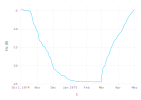

In [17]:
#High Elevation Seed Source Model
init = Date(1974, 10, 01)
last = Date(1975, 05, 01)
p74H = visualize(ColdHardinessEstimator, :t, :Hc;
    config = (calib_config_High, D6_1974_config),
    stop = :stop,
    kind = :line,
    xlim = ((init, last)),
)

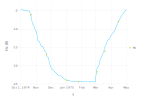

In [18]:
#High Elevation Seed Source Model Fit
plot!(p74H, Hc_Obs_High, :date, :Hc, kind=:scatter)

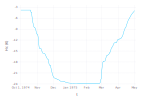

In [19]:
#Low Elevation Seed Source Model
init = Date(1974, 10, 01)
last = Date(1975, 05, 01)
p74L = visualize(ColdHardinessEstimator, :t, :Hc;
    config = (calib_config_Low, D6_1974_config),
    stop = :stop,
    kind = :line,
    xlim = ((init, last)),
)

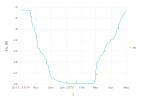

In [23]:
#Low Elevation Seed Source Model Fit
plot!(p74L, Hc_Obs_Low, :date, :Hc, kind=:scatter)

# Evaluation
Model fit is evaluated below. The statistic used is RMSE, which allow error to be in demonstrated in the same unit as the model. So RMSE can be considered as an average of how much error there is between preidcitons and observations. 

In [24]:
evaluate(ColdHardinessEstimator,  LowTest;
    config= @config(calib_config_Low, D6_1974_config), 
    index = :date,
    target = :Hc,
    stop = :stop,
    metric = :rmse,
)

2.313728944813495 K

In [25]:
evaluate(ColdHardinessEstimator,  HighTest;
    config= @config(calib_config_High, D6_1974_config), 
    index = :date,
    target = :Hc,
    stop = :stop,
    metric = :rmse,
)

0.7921563820280066 K